In [ ]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
sns.set_style('whitegrid')
from collections import Counter
from sklearn import preprocessing
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/


Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
ctu_data = pd.read_csv('/content/drive/MyDrive/netflow_botnet/capture20110810.csv')

In [ ]:
ctu_data.shape

(2824636, 15)

In [ ]:
ctu_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,flow=Background-UDP-Established
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,flow=Background
3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,flow=Background
4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,flow=Background-UDP-Established


### Converting o/p into 3 labels :background-0 botnet-1 and Normal-2

In [ ]:
def Label_op(value):
    new_val = (value.split("=",1))[1]
    if "Background" in new_val:
        return 0
    elif "Botnet" in new_val:
        return 1
    else:
        return 2
    
#background-0 botnet-1 and Normal-2
ctu_data["Final-Labels"] = ctu_data.Label.apply(Label_op)
ctu_data["Final-Labels"].value_counts()

0    2753288
1      40961
2      30387
Name: Final-Labels, dtype: int64

In [ ]:
ctu_data.drop(['Label','Dir'],axis=1,inplace=True)

In [ ]:
#finding missing values 
missing_counts = ctu_data.isnull().sum().sort_values(ascending=False)
missing_percent = ((ctu_data.isnull().sum()*100)/ctu_data.shape[0]).sort_values(ascending=False)
missing_df = pd.concat([missing_counts,missing_percent],axis=1,keys=['Counts','Percent'])
missing_df

,Counts,Percent
dTos,195190,6.910271
sTos,10590,0.374916
Sport,9379,0.332043
Dport,4390,0.155418
State,1,0.000035
Final-Labels,0,0.000000
SrcBytes,0,0.000000
TotBytes,0,0.000000
TotPkts,0,0.000000
DstAddr,0,0.000000


## **Preprocessing**

In [ ]:
#filling missing values and removing outliers
def ctu_preprocessing(df):
  #df.drop(['Label','Dir'],axis=1,inplace=True)
  df['sTos'] = df['sTos'].fillna(df['sTos'].mean())
  df['dTos'] = df['dTos'].fillna(df['dTos'].mean())
  df['Dport'].fillna(df.groupby('Proto')['Dport'].apply(lambda x:x.mode())[0],inplace=True)
  df['Sport'].fillna(df.groupby('Proto')['Sport'].apply(lambda x:x.mode())[0],inplace=True)
  df["TotPkts"] = df["TotPkts"].clip(lower = df["TotPkts"].quantile(0.15),upper = df["TotPkts"].quantile(0.85)) 
  df["TotBytes"] = df["TotBytes"].clip(lower = df["TotBytes"].quantile(0.15),upper = df["TotBytes"].quantile(0.85)) 
  df["SrcBytes"] = df["SrcBytes"].clip(lower = df["SrcBytes"].quantile(0.15),upper = df["SrcBytes"].quantile(0.85)) 
  return df

In [ ]:
ctu_data = ctu_preprocessing(ctu_data)

REMOVING PROTOCOLS WITH LESS THAN 100 VALUES (NOT CONVERTED USING LABEL ENCODER)

In [ ]:
protocols_del = ['ipv6','udt','esp','pim','rarp','unas','ipx/spx']
#temp_df = ctu_data[ctu_data.Proto in protocols_del]
index = ctu_data[((ctu_data.Proto =='ipv6')| (ctu_data.Proto =='udt')|(ctu_data.Proto == 'esp') | (ctu_data.Proto == 'pim')|(ctu_data.Proto == 'rarp')|(ctu_data.Proto == 'unas')|(ctu_data.Proto =='ipx/spx')|(ctu_data.Proto == 'ipv6-icmp'))].index
ctu_data.drop(index,inplace=True)
ctu_data.Proto.value_counts()

udp     2270083
tcp      507557
icmp      39694
rtp        2570
rtcp       2339
igmp       1803
arp         477
Name: Proto, dtype: int64

After removing outliers boxplot diagram

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


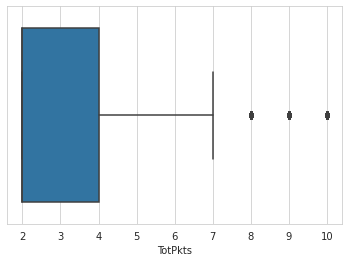

In [ ]:
sns.boxplot(ctu_data.TotPkts)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


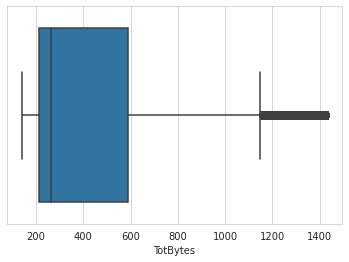

In [ ]:
sns.boxplot(ctu_data['TotBytes'])

## Time window code

In [ ]:
def RU(df):
    if df.shape[0] == 1:
        return 1.0
    else:
        proba = df.value_counts()/df.shape[0]
        h = proba*np.log10(proba)
        return -h.sum()/np.log10(df.shape[0])

In [ ]:
ctu_data.head()

,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Final-Labels,StartTime_new,Window_lower,Window_upper_excl
0,3550.182373,udp,212.50.71.179,39678,147.32.84.229,13363,CON,0.0,0.0,10,875,413,0,1.312970e+09,0.0,1.000000
1,0.000883,udp,84.13.246.132,28431,147.32.84.229,13363,CON,0.0,0.0,2,142,75,0,1.312970e+09,0.0,1.000026
2,0.000326,tcp,217.163.21.35,80,147.32.86.194,2063,FA_A,0.0,0.0,2,142,75,0,1.312970e+09,0.0,1.000044
3,0.056966,tcp,83.3.77.74,32882,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,0,1.312970e+09,0.0,1.000108
4,3427.768066,udp,74.89.223.204,21278,147.32.84.229,13363,CON,0.0,0.0,10,1430,733,0,1.312970e+09,0.0,1.000111


In [ ]:
def create_time_window(df):
  df['StartTime_new'] = pd.to_datetime(df['StartTime']).astype(np.int64)*(1e-9)
  start_time = df['StartTime_new'].min()
  window_width = 120
  window_stride = 60 
  df['Window_lower'] = (df['StartTime_new']-start_time-window_width)/window_stride+1
  df['Window_lower'].clip(lower=0,inplace=True)
  df['Window_upper_excl'] = (df['StartTime_new']-start_time)/window_stride+1
  df.drop('StartTime',inplace=True,axis=1)
  df = df.astype({"Window_lower": int, "Window_upper_excl": int})

  nb_windows = df['Window_upper_excl'].max()
  print(nb_windows)
  df.drop('StartTime_new', axis=1, inplace=True)
  X_nids = pd.DataFrame()
  for i in range(0,nb_windows):       #range is supposed to be nb_windows
    gb = df.loc[(df['Window_lower'] <= i) & (df['Window_upper_excl'] > i)].groupby('SrcAddr')
    X_nids = X_nids.append(gb.size().to_frame(name='counts').join(gb.agg({'Sport':['nunique',RU],
                                                          'Dport':['nunique',RU],
                                                         'Proto':['nunique',RU],
                                                         'Dur':['sum','mean','std','max','median'],
                                                         'TotPkts':['sum','mean','std','max','median'],
                                                         'SrcBytes':['sum','mean','std','max','median'],
                                                         'Final-Labels':lambda x: x.mode()[0]})).reset_index().assign(window_id=i))
  return X_nids


In [ ]:
X = pd.DataFrame()
X = create_time_window(ctu_data)

In [ ]:
X.shape

(2226533, 25)

In [ ]:
X.fillna(0,inplace=True)

In [ ]:
(X.loc[X.counts == 1]).head(10)


,SrcAddr,counts,"(Sport, nunique)","(Sport, RU)","(DstAddr, nunique)","(DstAddr, RU)","(Dport, nunique)","(Dport, RU)","(Proto, nunique)","(Proto, RU)","(Dur, sum)","(Dur, mean)","(Dur, std)","(Dur, max)","(Dur, median)","(TotPkts, sum)","(TotPkts, mean)","(TotPkts, std)","(TotPkts, max)","(TotPkts, median)","(SrcBytes, sum)","(SrcBytes, mean)","(SrcBytes, std)","(SrcBytes, max)","(SrcBytes, median)","(Final-Labels, <lambda>)",window_id
0,0.0.0.0,1,1,1.0,1,1.0,1,1.0,1,1.0,3592.177734,3592.177734,NaN,3592.177734,3592.177734,10,10.0,NaN,10,10.0,732,732.0,NaN,732,732.0,0,0
1,1.144.156.226,1,1,1.0,1,1.0,1,1.0,1,1.0,0.003020,0.003020,NaN,0.003020,0.003020,2,2.0,NaN,2,2.0,75,75.0,NaN,75,75.0,0,0
2,1.144.5.55,1,1,1.0,1,1.0,1,1.0,1,1.0,0.002826,0.002826,NaN,0.002826,0.002826,2,2.0,NaN,2,2.0,475,475.0,NaN,475,475.0,0,0
3,1.155.150.224,1,1,1.0,1,1.0,1,1.0,1,1.0,0.000879,0.000879,NaN,0.000879,0.000879,2,2.0,NaN,2,2.0,75,75.0,NaN,75,75.0,0,0
4,1.161.139.96,1,1,1.0,1,1.0,1,1.0,1,1.0,1509.379883,1509.379883,NaN,1509.379883,1509.379883,10,10.0,NaN,10,10.0,732,732.0,NaN,732,732.0,0,0
5,1.227.147.225,1,1,1.0,1,1.0,1,1.0,1,1.0,0.000000,0.000000,NaN,0.000000,0.000000,2,2.0,NaN,2,2.0,173,173.0,NaN,173,173.0,0,0
6,1.66.98.179,1,1,1.0,1,1.0,1,1.0,1,1.0,3341.880615,3341.880615,NaN,3341.880615,3341.880615,10,10.0,NaN,10,10.0,732,732.0,NaN,732,732.0,0,0
7,1.66.99.138,1,1,1.0,1,1.0,1,1.0,1,1.0,951.644653,951.644653,NaN,951.644653,951.644653,4,4.0,NaN,4,4.0,150,150.0,NaN,150,150.0,0,0
8,1.66.99.29,1,1,1.0,1,1.0,1,1.0,1,1.0,3565.326904,3565.326904,NaN,3565.326904,3565.326904,10,10.0,NaN,10,10.0,732,732.0,NaN,732,732.0,0,0
9,1.72.0.253,1,1,1.0,1,1.0,1,1.0,1,1.0,3408.692383,3408.692383,NaN,3408.692383,3408.692383,10,10.0,NaN,10,10.0,732,732.0,NaN,732,732.0,0,0


Text(0.5, 1.05, 'Pearson Correlation of All Features')

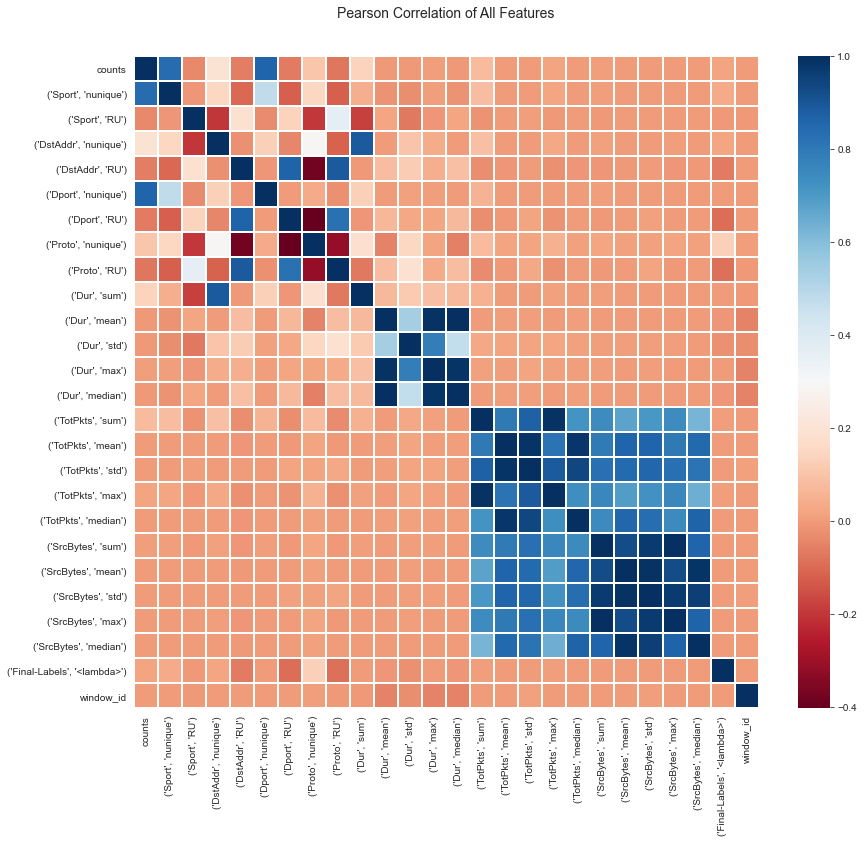

In [ ]:
plt.figure(figsize=(14,12))

# plot heatmap set the title
colormap = plt.cm.RdBu
sns.heatmap(X.corr(),linewidths=0.1,vmax=1.0, 
            square=False, cmap=colormap, linecolor='white', annot=False)
plt.title('Pearson Correlation of All Features', y=1.05, size=14)

Feature Correlation with Label

In [ ]:
correlations = pd.DataFrame(X.corr())
correlations = pd.DataFrame(correlations['Final-Labels', '<lambda>']).reset_index()
correlations.columns = ["Feature", "Correlation with Label"]
correlations = (correlations[correlations["Feature"] != "'Final-Labels', '<lambda>'"]
                .sort_values(by="Correlation with Label", ascending=True))
display(correlations)

,Feature,Correlation with Label
6,"(Dport, RU)",-0.097747
8,"(Proto, RU)",-0.092552
4,"(DstAddr, RU)",-0.071466
11,"(Dur, std)",-0.022923
2,"(Sport, RU)",-0.017196
13,"(Dur, median)",-0.011371
10,"(Dur, mean)",-0.010590
21,"(SrcBytes, std)",-0.000702
12,"(Dur, max)",-0.000674
18,"(TotPkts, median)",-0.000111


In [ ]:
y = X['Final-Labels', '<lambda>']

In [ ]:
X1 = X.iloc[:,2:23]

# Training model

Splitting dataset into 80% training and 20% validation.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, random_state=1)

In [ ]:
X_valid.shape

(445307, 21)

In [ ]:
from sklearn.metrics import accuracy_score
def fit_evaluate_model(model, X_train, y_train, X_valid, Y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return accuracy_score(y_valid, y_predicted),y_predicted

In [ ]:
rf_classifier = RandomForestClassifier()
rf_accuracy,y_predicted = fit_evaluate_model(rf_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", rf_accuracy)

Number of correct predictions made out of all predictions are: 0.9997844183900096


In [ ]:
from sklearn.metrics import classification_report
def print_results(y_predicted,y_valid):
  print('Confusion Matrix')
  print(confusion_matrix(y_valid, y_predicted))
  target_names = ['Background', 'Botnet','Foreground']
  print(classification_report(y_valid, y_predicted, target_names=target_names))
  return
  

Confusion Matrix and Classification Report for Random Forest


In [ ]:
print_results(y_predicted, y_valid)

Confusion Matrix
[[445028      0     17]
 [     1     51      0]
 [    78      0    132]]
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    445045
      Botnet       1.00      0.98      0.99        52
  Foreground       0.89      0.63      0.74       210

    accuracy                           1.00    445307
   macro avg       0.96      0.87      0.91    445307
weighted avg       1.00      1.00      1.00    445307



Random Forest Model trained with class weights

In [ ]:
model = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
rf_accuracy,y_predicted = fit_evaluate_model(model, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", rf_accuracy)


Number of correct predictions made out of all predictions are: 0.9997237860621998


In [ ]:
print_results(y_predicted, y_valid)

Confusion Matrix
[[445001      0     44]
 [     3     49      0]
 [    76      0    134]]
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    445045
      Botnet       1.00      0.94      0.97        52
  Foreground       0.75      0.64      0.69       210

    accuracy                           1.00    445307
   macro avg       0.92      0.86      0.89    445307
weighted avg       1.00      1.00      1.00    445307



Pickle to store weights

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
y_predicted1 = loaded_model.predict(X_valid)
print_results(y_predicted1, y_valid)

Confusion Matrix
[[445001      0     44]
 [     3     49      0]
 [    76      0    134]]
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    445045
      Botnet       1.00      0.94      0.97        52
  Foreground       0.75      0.64      0.69       210

    accuracy                           1.00    445307
   macro avg       0.92      0.86      0.89    445307
weighted avg       1.00      1.00      1.00    445307



Parameter tuning for random trees

In [ ]:
n_estimators = [50, 100, 300, 500, 1000]

# The minimum number of samples required to be at a leaf node, default value is 1.
min_samples_leaf = [1, 2, 4, 6, 8]

# The number of features to consider when looking for the best split, default value is auto.
max_features = ['auto', 'sqrt', 'log2', None] 

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
tuned_model = RandomForestClassifier()

# create Randomized search object
random_cv = RandomizedSearchCV(estimator=tuned_model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=15, 
                               scoring = 'accuracy',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True, 
                               )
random_cv.fit(X_train_tune, y_train_tune)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'n_estimators': [100, 300, 500, 1000]},
                   return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
random_forest_tuned = RandomForestClassifier(n_estimators = 1000,min_samples_leaf = 1,max_features='sqrt')
rf_accuracy,y_predicted = fit_evaluate_model(random_forest_tuned,X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", rf_accuracy)

Number of correct predictions made out of all predictions are: 0.9997821727482389


In [ ]:
print_results(y_predicted, y_valid)

Confusion Matrix
[[445029      0     16]
 [     1     51      0]
 [    80      0    130]]
Classification Report
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    445045
      Botnet       1.00      0.98      0.99        52
      Normal       0.89      0.62      0.73       210

    accuracy                           1.00    445307
   macro avg       0.96      0.87      0.91    445307
weighted avg       1.00      1.00      1.00    445307



Extra Trees Classifier

In [ ]:
xrf_classifier = ExtraTreesClassifier()
xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", xrf_accuracy)

Number of correct predictions made out of all predictions are: (0.9998113660912584, array([0, 0, 0, ..., 0, 0, 0]))


XGB Classifier

In [ ]:
xgb_classifier = XGBClassifier()
xgb_accuracy,y_predicted = fit_evaluate_model(xgb_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", xgb_accuracy)

Number of correct predictions made out of all predictions are: 0.9996811188685558


In [ ]:
print_results(y_predicted, y_valid)

Confusion Matrix
[[445029      0     16]
 [     1     51      0]
 [   125      0     85]]
Classification Report
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    445045
      Botnet       1.00      0.98      0.99        52
      Normal       0.84      0.40      0.55       210

    accuracy                           1.00    445307
   macro avg       0.95      0.80      0.85    445307
weighted avg       1.00      1.00      1.00    445307



Class weights with XGB

In [ ]:
xgb_classifier = XGBClassifier(class_weight='balanced_subsample')
xgb_accuracy,y_predicted = fit_evaluate_model(xgb_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", xgb_accuracy)

Number of correct predictions made out of all predictions are: 0.9996811188685558


In [ ]:
print_results(y_predicted, y_valid)

Confusion Matrix
[[445029      0     16]
 [     1     51      0]
 [   125      0     85]]
Classification Report
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    445045
      Botnet       1.00      0.98      0.99        52
      Normal       0.84      0.40      0.55       210

    accuracy                           1.00    445307
   macro avg       0.95      0.80      0.85    445307
weighted avg       1.00      1.00      1.00    445307



# Testing model with a different dataset of botnet - Virut

In [ ]:
virut_data = pd.read_csv('/content/drive/MyDrive/netflow_botnet/malware43.csv')

In [ ]:
#for virut
virut_data["Final-Labels"] = virut_data.Label.apply(Label_op)
virut_data["Final-Labels"].value_counts()

0    1778061
1      20941
2       9120
Name: Final-Labels, dtype: int64

In [ ]:
virut_data = ctu_preprocessing(virut_data)


In [ ]:
protocols_del = ['ipv6','udt','esp','pim','rarp','unas','ipx/spx','gre']
#temp_df = ctu_data[ctu_data.Proto in protocols_del]
index = virut_data[((virut_data.Proto =='ipv6')| (virut_data.Proto =='udt')|(virut_data.Proto == 'esp') | (virut_data.Proto == 'pim')|(virut_data.Proto == 'rarp')|(virut_data.Proto == 'unas')|(virut_data.Proto =='ipx/spx')|(virut_data.Proto == 'ipv6-icmp'))].index
virut_data.drop(index,inplace=True)

In [ ]:
X_test = pd.DataFrame()
X_test = create_time_window(virut_data)

In [ ]:
y_test = X['Final-Labels', '<lambda>']
X_test = X.iloc[:,2:23]

In [ ]:
X_test.fillna(0,inplace=True)

In [ ]:
y_test_predicted = model.predict(X_test)

In [ ]:
print_results(y_test_predicted,y_test)

Confusion Matrix
[[2224638       0     577]
 [      3     283       0]
 [    121       0     911]]
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00   2225215
      Botnet       1.00      0.99      0.99       286
  Foreground       0.61      0.88      0.72      1032

    accuracy                           1.00   2226533
   macro avg       0.87      0.96      0.91   2226533
weighted avg       1.00      1.00      1.00   2226533

